In [16]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

import cnv_inference_config
project_config = cnv_inference_config
os.chdir(project_config.MB_ROOT)

from collections import defaultdict, OrderedDict
import multiprocessing as mp
import sys

import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from data_types import ase
import plotlib
import toolkit
import util
import test_phasing
from workspace.workspace_manager import WorkspaceManager

workspace = WorkspaceManager(
    task_name="counts_to_ase",
    experiment_info={"data" : "scRNA"},
    verbose=True
)
workspace.load_workspace()

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

In [17]:
requirements = ["raw_counts", "phasing", "genome"]

data = {
    dtype : 
    util.pickle_load(workspace.tmp_data[dtype])
    for dtype in tqdm_notebook(
        requirements,
        "loading datasets into RAM"
    )
}

In [18]:
# data["raw_counts"].drop(columns=["PHASE"], inplace=True)

In [19]:
all_snps = toolkit.extract_snps(data["raw_counts"])
haplotype_snps = toolkit.extract_snps(data["phasing"])
common_snps = np.intersect1d(all_snps, haplotype_snps)

In [20]:
new_cols = []
phased_mask =  np.isin(all_snps, common_snps)
for col in tqdm_notebook(data["raw_counts"].columns):
    new_cols.append(
        data["raw_counts"][col]\
        .to_dense()\
        [phased_mask]\
        .to_sparse()
    )
new_df = pd.concat(new_cols, axis=1)
new_df.head()

,CHROM,POS,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
44,1.0,817842.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,1.0,817964.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,1.0,817969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,1.0,817980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,1.0,849998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
data["raw_counts"] = new_df.reset_index(drop=True)

In [22]:
phased_mask = np.isin(haplotype_snps, common_snps)
data["phasing"] = data["phasing"][phased_mask].reset_index(drop=True)

In [23]:
# data["phasing"].drop(columns="PHASE", inplace=True)

In [24]:
data["phasing"].drop_duplicates(inplace=True)

### Loading raw read counts

In [25]:
# def load_raw_counts(chunksize = 2**16):
#     if os.path.exists(f"{sample_data_dir}/raw_counts.pkl"):
#         # this is much faster than reading in chunks and concatenating those
#         raw_counts_df = util.pickle_load(f"{sample_data_dir}/raw_counts.pkl")
#     else:
        
#         reader = pd.read_csv(f"{sample_data_dir}/raw_counts.csv", 
#                              dtype=np.float64, 
#                              chunksize=chunksize)
#         raw_counts_df = pd.concat(
#             [chunk.to_sparse() for chunk in 
#              tqdm_notebook(reader, 
#                            desc=f"reading counts in chunks of size {chunksize}")]
#         )
#         util.pickle_dump(raw_counts_df, f"{sample_data_dir}/raw_counts.pkl")
#     return raw_counts_df

In [26]:
# util.nan_fraction(
#     raw_counts_df, 
#     axis_list=[0], 
#     verbose=True, 
#     show_plots=True,
#     suptitle="raw_counts_df"
# );

### Loading reference genome

In [27]:
# def load_genome():
#     # genome_df = pd.read_csv(
#     #     f"{root_data_dir}/genome_binning_1mb.tsv", 
#     #     sep='\t',
#     #     names=["CHROM", "START", "END", "GENE_ID"]
#     # )
#     genome_df = pd.read_csv(f"{root_data_dir}/genome.csv")
#     assert np.all(np.isin(["CHROM", "START", "END", "GENE_ID"], 
#                           genome_df.columns))
#     return genome_df

In [28]:
# genome_df = load_genome()
# genome_df.head()

In [29]:
# genome_df.to_pickle(f"{sample_data_dir}/genome.pkl")

### Loading phasing information

In [30]:
# def load_phasing_info(raw_counts_df):
#     phasing_df = pd.read_csv(f"{root_data_dir}/phasing.csv")
#     assert np.all(np.isin(["CHROM", "POS", "PHASE"], phasing_df.columns))
#     phasing_df = phasing_df.merge(raw_counts_df[["CHROM", "POS"]].to_dense())
#     assert phasing_df.shape[0] == raw_counts_df.shape[0]
#     return phasing_df

In [31]:
# phasing_df = load_phasing_info(raw_counts_df)
# phasing_df.head()

In [32]:
# phasing_df.to_pickle(f"{sample_data_dir}/phasing.pkl")

## Ensuring that alternative allele is maternal (0|1 in raw phasing results)

In [33]:
def load_counts(raw_counts_df, phasing_df):
#     if os.path.exists(f"{sample_data_dir}/counts.pkl"):
#         counts_df = util.pickle_load(f"{sample_data_dir}/counts.pkl")
#     else:
    counts_df = raw_counts_df.copy()
    counts_df["PHASE"] = phasing_df.PHASE
    male_alt = counts_df.PHASE == 1

    for barcode in tqdm_notebook(toolkit.extract_barcodes(counts_df), 
                                 desc=f"cell_barcode"):
        ad = counts_df[f"{barcode}_ad"].to_dense()
        dp = counts_df[f"{barcode}_dp"].to_dense()
        ad[male_alt] = dp[male_alt].sub(ad[male_alt], fill_value=0)
        counts_df[f"{barcode}_ad"] = ad.to_sparse()

    new_nan_stats = util.nan_fraction(counts_df.drop(columns=["PHASE"]))
    old_nan_stats = util.nan_fraction(raw_counts_df)

    assert old_nan_stats == new_nan_stats
#     util.pickle_dump(counts_df, f"{sample_data_dir}/counts.pkl")

    print("Ensuring that non-phased SNPs were filtered out")
    assert np.all(np.isin(toolkit.extract_snps(counts_df), 
                  toolkit.extract_snps(phasing_df)))

    print("{:.2f}% of non-missing read counts".format(
        100 * counts_df.density
    ))
    return counts_df

In [34]:
%%time
data["counts"] = load_counts(data["raw_counts"], data["phasing"])
data["counts"].head()

Ensuring that non-phased SNPs were filtered out


0.07% of non-missing read counts
CPU times: user 6min, sys: 12.5 s, total: 6min 13s
Wall time: 6min 11s


,CHROM,POS,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,...,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp,PHASE
0,1.0,817842.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1.0,817964.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.0,817969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1.0,817980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1.0,849998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [35]:
util.pickle_dump(
    data["phasing"],
    os.path.join(
        workspace.tmp_dir,
        "cnv_^_haplotype_block_phasing.pkl"
    )
)
workspace.add_entry("cnv_^_haplotype_block_phasing", "cnv_^_haplotype_block_phasing.pkl")
workspace.verify()
workspace.push()

/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/counts_to_ase/first_sample/scRNA/cnv_^_haplotype_block_phasing.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/first_sample/scRNA/cnv_^_haplotype_block_phasing.pkl


In [36]:
util.pickle_dump(
    data["counts"],
    os.path.join(
        workspace.tmp_dir,
        "cnv_^_haplotype_block_counts.pkl"
    )
)
workspace.add_entry("cnv_^_haplotype_block_counts", 
                    "cnv_^_haplotype_block_counts.pkl")
workspace.verify()
workspace.push()

/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/counts_to_ase/first_sample/scRNA/cnv_^_haplotype_block_phasing.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/first_sample/scRNA/cnv_^_haplotype_block_phasing.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/counts_to_ase/first_sample/scRNA/cnv_^_haplotype_block_counts.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/first_sample/scRNA/cnv_^_haplotype_block_counts.pkl


In [37]:
data["counts"].info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 232300 entries, 0 to 232299
Columns: 13341 entries, CHROM to PHASE
dtypes: Sparse[float64, nan](13340), Sparse[int64, nan](1)
memory usage: 24.2 MB


## Getting an ASE matrix and selecting informative genes from it

In [18]:
%%time
gene_counts_df = util.pickle_load(f"{sample_data_dir}/gene_counts.pkl")
ase_df = ase_matrix.compute_ase(
    gene_counts_df, 
    toolkit.extract_barcodes(gene_counts_df)
)
util.pickle_dump(ase_df, f"{sample_data_dir}/ase.pkl")
ase_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10224 entries, 0 to 10223
Columns: 6126 entries, AAACCTGCACATCCAA-1 to TTTGTCATCCCAAGAT-1
dtypes: float64(6126)
memory usage: 477.8 MB
CPU times: user 9.84 s, sys: 12.5 s, total: 22.4 s
Wall time: 29.9 s


Per column:
AAACCTGCACATCCAA-1    0.997164
AAACCTGCACTAGTAC-1    0.996088
AAACCTGCATCATCCC-1    0.997555
AAACCTGGTAGCTCCG-1    0.995794
AAACCTGGTCTAAACC-1    0.994914
                        ...   
TTTGTCAGTGCGCTTG-1    0.989241
TTTGTCAGTGTTTGTG-1    0.993642
TTTGTCAGTTAAAGAC-1    0.995794
TTTGTCATCATCGGAT-1    0.991784
TTTGTCATCCCAAGAT-1    0.995012
Length: 6126, dtype: float64
Per row:
0        0.990042
1        0.999674
2        0.999510
3        0.999347
4        0.996898
           ...   
10219    0.999347
10220    0.999837
10221    0.998368
10222    0.999837
10223    0.999837
Length: 10224, dtype: float64
In total:  0.9948370985516976


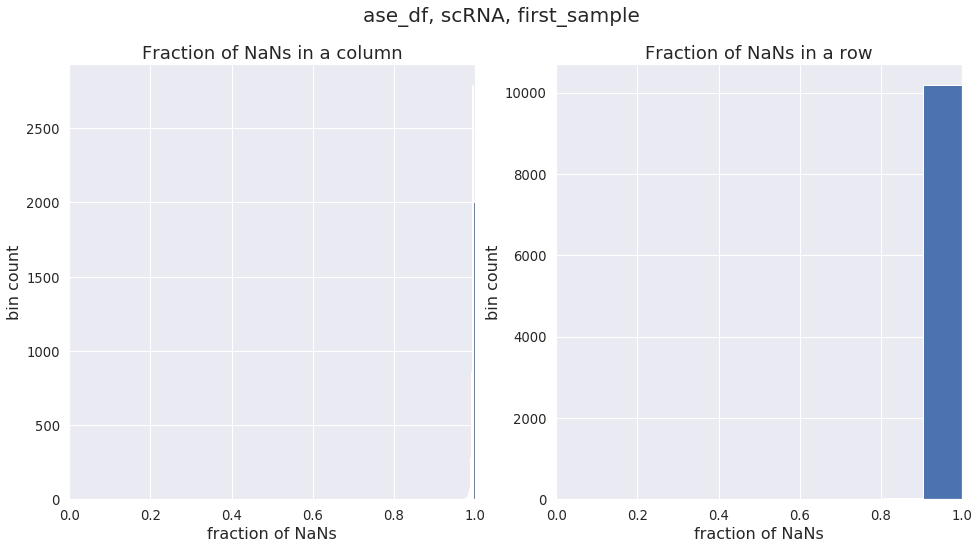

In [19]:
nan_info = util.nan_fraction(
    ase_df, 
    axis_list=[0,1],
    verbose=True, 
    show_plots=True,
    suptitle=f"ase_df, {data_name}, {sample_name}"
);

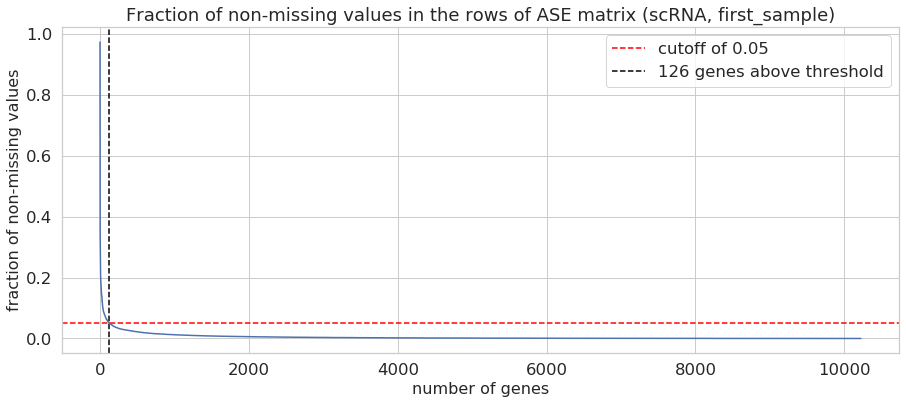

In [40]:
import ipywidgets as widgets

def plot_selection_by_nan_fraction(nan_info, cutoff=0.1, outfile=os.devnull):
    plt.figure(figsize=(15,6))
    plt.title("Fraction of non-missing values in the rows of ASE matrix ({}, {})"\
              .format(data_name, sample_name), fontsize=18)
    plt.xlabel("number of genes", fontsize=16);
    plt.ylabel("fraction of non-missing values", fontsize=16)
    n_remaining_genes = (1 - nan_info["row"] >= 1 - cutoff).sum()
    plt.axhline(
        1-cutoff, 
        color="red", 
        linestyle="--", 
        label="cutoff of {:.2f}".format(1-cutoff)
    );
    plt.axvline(n_remaining_genes, 
                color="black", linestyle="--", 
                label=f"{n_remaining_genes} genes above threshold")
    plt.plot(sorted(1 - nan_info["row"])[::-1]);
    plt.legend().get_frame().set_facecolor("white");
    plt.savefig(outfile, format=outfile.split('.')[-1], dpi=300)

plot_selection_by_nan_fraction(
    nan_info, 
    cutoff=0.95, 
    outfile=f"{sample_img_dir}/nans_with_threshold.pdf"
)